In [1]:
#Third party packages
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline

#Custom packages
from SQL.load_rows import load_cluster_labels, load_a_cluster_label, load_intensity
import Audio.cluster_audio_features as cluster_funcs


In [2]:
def import_class_data(youtube_id, folder = '~/Insight2017/Labelled_Data/'):
    filename = folder+str(youtube_id)+'.csv'
    try: classification_results = pd.read_csv(filename, header=None, names=['Time','Speaker'])
    except IOError:
        print('No file found, check youtube ID and folder!')
    return classification_results

def speaker_label_to_num(classification_results):
    '''takes string labels for speaker like A or B and
    converts to unique integers'''
    labels = classification_results.Speaker.unique()
    classes = classification_results.Speaker.values
    int_labels = np.zeros(classification_results.Speaker.shape)
    for n, label in enumerate(labels):
        int_labels[classes==label] = n
        
    return int_labels

def time_string_to_sec(classification_results):
    '''convert from mm:ss time string into seconds'''
    times = np.zeros(classification_results.Time.shape)
    
    for n,time in enumerate(classification_results.Time):
        elements = time.split(":")
        times[n] = 60*int(elements[0])+int(elements[1])
    return times

def produce_speaker_vector(times, classification_results):
    '''takes some hand-recorded data for speakers in a video and uses them
    to classify the speaker for every time element in the time vector "times" '''
    
    results = np.zeros(times.shape)
    
    class_times = time_string_to_sec(classification_results)
    class_labels = speaker_label_to_num(classification_results)
    
    results[times<class_times[0]] = class_labels[0]
    for n,label in enumerate(class_labels):
        speaker_times = (times<class_times[n]) & (times > class_times[n-1])
        results[speaker_times] = label
        
    return results

Specify the Youtube File
---

In [3]:
youtube_id = '5qsVB5ZmrD4'

Load the cluster predictions from PostgreSQL Database
---

In [4]:
#cluster_df = load_cluster_labels(youtube_id)

#cluster_times = cluster_df['time'].as_matrix()
#cluster_labels = cluster_df['cluster_label_raw'].as_matrix()

In [5]:
# or recalculate using the algorithm, based on the features in the SQL database
cluster_times, cluster_labels = cluster_funcs.calc_cluster_labels(youtube_id)

Total number of feature rows: 439


In [6]:
# also calculate the clusters using my new minority removal function
cluster_times, cluster_labels = cluster_funcs.calc_cluster_labels_with_rejection(youtube_id)

Total number of feature rows: 439


Load the human labels from .csv file
---

In [7]:
class_df = import_class_data(youtube_id)

t_max = time_string_to_sec(class_df).max()
true_classes = produce_speaker_vector(cluster_times, class_df)

Find the accuracy
---

In [8]:
accuracy = np.mean(true_classes == cluster_labels)
if accuracy < 0.5:
    accuracy = 1-accuracy
    true_classes = np.logical_not(true_classes.astype(bool)).astype(int)
print('Second-by-second accuracy is %d%%' % int(100*accuracy))
triv_accuracy = true_classes.mean()
if triv_accuracy < 0.5:
    triv_accuracy = 1-triv_accuracy
print('Trivial accuracy would be %d%%' % int(100*triv_accuracy))

Second-by-second accuracy is 57%
Trivial accuracy would be 76%


Compare the two graphically
---

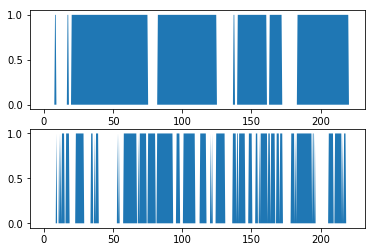

In [9]:
plt.subplot(211)
plt.fill_between(cluster_times, 0, true_classes)
plt.subplot(212)
plt.fill_between(cluster_times, 0, cluster_labels)